# Forecasting examples


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import keras
import  matplotlib.pyplot as plt

from foressment_ai.forecasting.forecaster_ai.forecaster import NaiveForecaster, AIForecaster, ForecastEstimator, TSGenerator
from foressment_ai.forecasting.forecaster_ai.loader import DataLoaderAndPreprocessorDefault

### Download and prepare the dataset.

In [2]:
dataset = DataLoaderAndPreprocessorDefault()
dataset.generate_test_data(shape=(1000,1))
dataset.set_train_size(0.8)

pd.DataFrame(dataset.data, columns=dataset.feature_names).head(5)

,feature_0
0,0.275452
1,0.031494
2,-0.138114
3,0.153189
4,0.324553


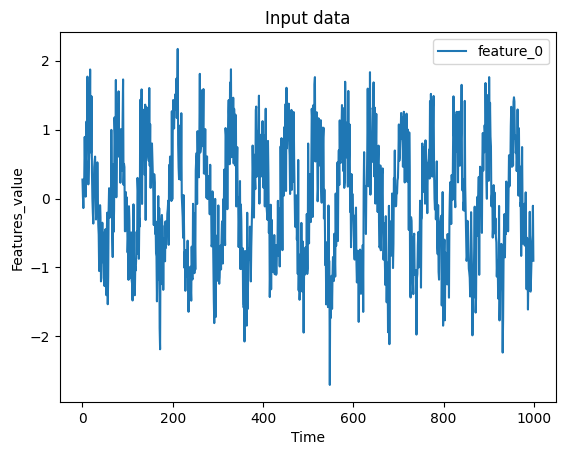

In [3]:
for i, f in enumerate(dataset.feature_names):
    plt.plot(dataset.data[:, i], label=f)

plt.title('Input data')
plt.ylabel('Features_value')
plt.xlabel('Time')
plt.legend()
plt.show()

Get train and test samples.

In [4]:
train = dataset.get_train_data()
test = dataset.get_test_data()

print('Train data:', train.data.shape)
print('Test data:', test.data.shape)

Train data: (800, 1)
Test data: (200, 1)


Normalization

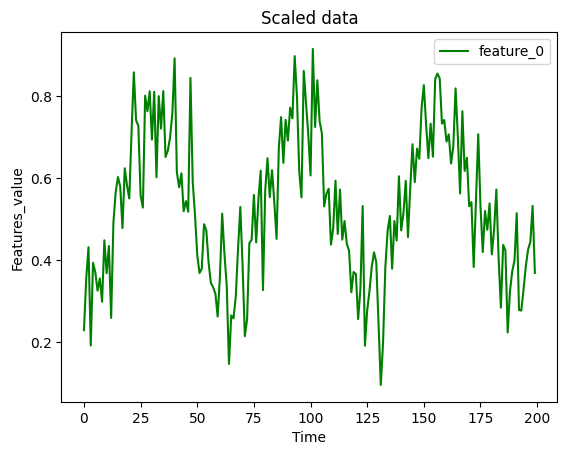

In [5]:
train.scale()
test.scale(scaler=train.scaler)

for i, f in enumerate(test.feature_names):
    plt.plot(test.data[:, i], label=f, color='g')

plt.title('Scaled data')
plt.ylabel('Features_value')
plt.xlabel('Time')
plt.legend()
plt.show()

Create time series generators.

In [6]:
look_back_length = 50
horizon = 1
forecasting_data_length = test.data.shape[0]-look_back_length

ts_train = TSGenerator(train.data, look_back_length=look_back_length, horizon=horizon)
ts_test = TSGenerator(test.data, look_back_length=look_back_length, horizon=forecasting_data_length)

#Data shape = (n_time_window, look_back_length, n_features)
print('Train timeseries data:', ts_train.data.shape)
print('Test timeseries data:', ts_test.data.shape)

#Train target shape = (n_time_window, horizon, n_features)
print('Train timeseries targets:', ts_train.targets.shape)
#Test target shape = (n_time_window, forecasting_data_length, n_features)
print('Test timeseries targets:', ts_test.targets.shape)

Train timeseries data: (750, 50, 1)
Test timeseries data: (1, 50, 1)
Train timeseries targets: (750, 1, 1)
Test timeseries targets: (1, 150, 1)


Get current data to forecasting.

In [7]:
current_batch = ts_test.get_data(window_id=0)
print('Data for forecasting:', current_batch.shape)

Data for forecasting: (1, 50, 1)


### Naive forecast

Define the baseline model.

In [8]:
nm = NaiveForecaster(look_back_length=look_back_length, horizon=horizon, n_features=len(train.feature_names))

Make a naive forecast.

In [9]:
naive_pred = nm.forecasting(current_batch, forecasting_data_length=forecasting_data_length)

Forecasting: 100%|██████████| 150/150 [00:00<00:00, 16710.37it/s]


### Deep forecast

Define the deep forecasting model.

In [10]:
fm = AIForecaster(look_back_length=look_back_length, horizon=horizon, n_features=len(train.feature_names))

Determine the value of hyperparameters for tuning.

In [11]:
tuned_hps = {
             'units': [[512, 400, 316], [256, 160, 80], [64, 32, 16]],
             'dropout': [0.0, 0.01, 0.5],
             'hidden_activation': ['tanh', 'relu'],
             'output_activation': ['linear', 'sigmoid']
            }
fm.set_tuned_hps(tuned_hps)
print(fm.hp_choices)

{'units_0': [512, 400, 316], 'units_1': [256, 160, 80], 'units_2': [64, 32, 16], 'dropout': [0.0, 0.01, 0.5], 'hidden_activation': ['tanh', 'relu'], 'output_activation': ['linear', 'sigmoid']}


Run the hyperparameter search. Find the optimal hyperparameters and model.

In [12]:
fm.find_best_model(x=ts_train.get_data(),
                   y=ts_train.get_targets(),
                   tuner_type='BayesianOptimization',
                   num_models=10,
                   epochs=5)

Trial 10 Complete [00h 01m 07s]
loss: 0.012097420170903206

Best loss So Far: 0.010979749262332916
Total elapsed time: 00h 14m 15s
INFO:tensorflow:Oracle triggered exit

 Optimal model parameters:
units_0 : 316
units_1 : 80
units_2 : 64
dropout : 0.01
hidden_activation : relu
output_activation : sigmoid
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 316)           401952    
                                                                 
 dropout (Dropout)           (None, 50, 316)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 80)            127040    
                                                                 
 dropout_1 (Dropout)         (None, 50, 80)            0         
                                                                 
 lstm_2 (LSTM) 

Save deep forecasting model configuration.

In [13]:
param_filename = fm.model_hps['block_type'].lower() + '_' + '_'.join(str(u) for u in fm.model_hps['units'])
filename = 'ai_models/configs/' + param_filename+'.json'
fm.save_model_config(filename)
print('Model configuration save to', filename)

Model configuration save to ai_models/configs/lstm_316_80_64.json


Train model.

In [14]:
fm.train(X=ts_train.get_data(), y=ts_train.get_targets(),
         batch_size=16, n_epochs=30, validation_split=0.1)

Epoch 1/30
43/43 [==============================] - 21s 314ms/step - loss: 0.0335 - val_loss: 0.0275
Epoch 2/30
43/43 [==============================] - 9s 210ms/step - loss: 0.0291 - val_loss: 0.0254
Epoch 3/30
43/43 [==============================] - 9s 219ms/step - loss: 0.0265 - val_loss: 0.0235
Epoch 4/30
43/43 [==============================] - 13s 309ms/step - loss: 0.0336 - val_loss: 0.0199


Save trained model.

In [15]:
filename = 'ai_models/ready/'+param_filename+'.h5'
fm.save_model(filename)
print('Model save to', filename)

Model save to ai_models/ready/lstm_316_80_64.h5


Make a deep forecast.

In [16]:
pred = fm.forecasting(current_batch,
                      forecasting_data_length=forecasting_data_length)

Forecasting: 100%|██████████| 150/150 [00:14<00:00, 10.60it/s]


### Evaluation

In [17]:
estimator = ForecastEstimator(feature_names=test.feature_names)
estimator.set_current_data(current_batch)
estimator.set_true_values(ts_test.get_targets())

estimator.set_naive_pred_values(naive_pred)
estimator.set_pred_values(pred)

estimator.estimate()
print(estimator.quality)

              pred_MSE  pred_MAE  naive_MSE  naive_MAE
feature_0      0.01413  0.096356   0.030559   0.144475
ALL_FEATURES   0.01413  0.096356   0.030559   0.144475


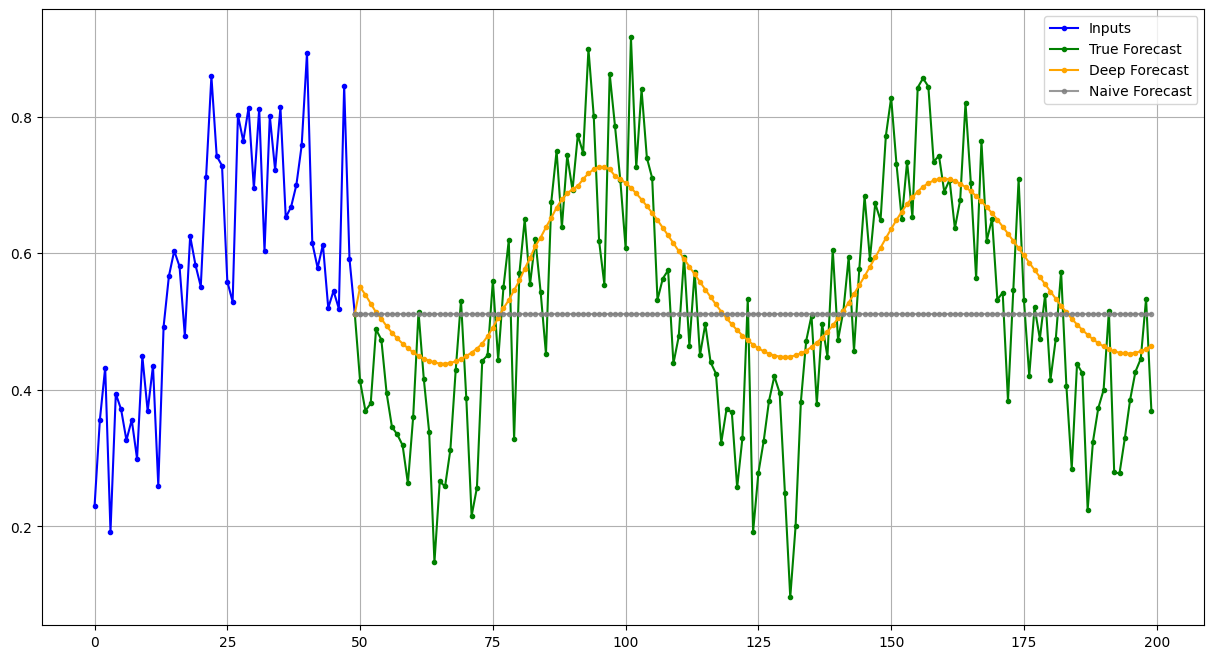

In [18]:
estimator.draw()